In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pvlib

import energydatamodel as edm
import enflow as ef

import gymnasium as gym

#from Utilities.PV_AC_Output import PV_AC_Output
#from Utilities.Data_import import calculate_retail_price
#from Utilities import Plot, KPI

#from Models.PV_BESS_LP_opt import PV_BESS_LP_solver
#from Models.PV_BESS_LP_time_horizon import PV_BESS_LP_Time_horizon_v2

In [8]:
df_demand = pd.read_csv("data/electricity_demand.csv", index_col=0, parse_dates=True)
df_meteo = pd.read_csv("data/meteo_data.csv", index_col=0, parse_dates=True)

### 1) Create energy system

In [15]:
pv_system = edm.PVSystem(name="my_pvsystem",
                         surface_tilt=30,
                         surface_azimuth=180,
                         capacity=4,
                         module_type='glass_polymer',
                         module_parameters={'gamma_pdc': -0.004})

bess_system = edm.Battery(name="my_battery",
                          storage_capacity=8,   
                       min_soc=0.1,               
                       max_charge=0.5,           
                       max_discharge=0.5,     
                       charge_efficiency=1, 
                       discharge_efficiency=1)

building = edm.Building(name="my_building",
                        location=edm.Location(longitude=13.511144, latitude=59.391022, tz='Europe/Stockholm'),
                        assets=[pv_system, bess_system])

In [16]:
# Calculate pv output data
pvlib_system = pv_system.to_pvlib()
pvlib_location = building.location.to_pvlib()

solarposition = pvlib_location.get_solarposition(df_meteo.index)
dni_dhi = pvlib.irradiance.erbs(ghi=df_meteo['ghi'].values, 
                                 zenith=solarposition['zenith'].values, 
                                 datetime_or_doy=df_meteo.index.dayofyear.values)
df_meteo["dni"] = dni_dhi["dni"]
df_meteo["dhi"] = dni_dhi["dhi"]

modelchain = pvlib.modelchain.ModelChain(pvlib_system, pvlib_location, dc_model='pvwatts', aoi_model='no_loss', spectral_model='no_loss')
df_pv_output_clearsky = modelchain.run_model(weather=pvlib_location.get_clearsky(times=df_demand.index)).results.dc
df_pv_output = modelchain.run_model(weather=df_meteo).results.dc


In [17]:
df = pd.concat([df_demand, df_pv_output_clearsky, df_pv_output], 
                axis=1)
df.columns = ["demand", "pv_output_clearsky", "pv_output"]

<Axes: >

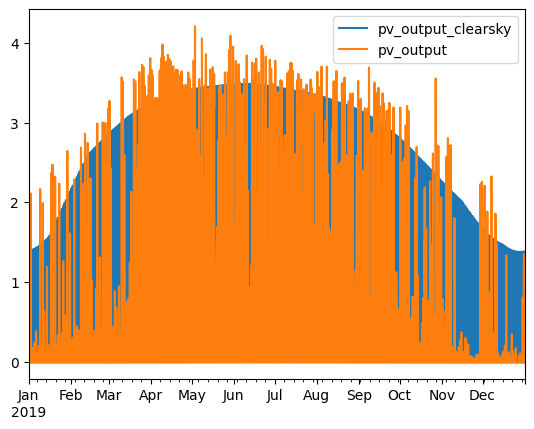

In [19]:
df[["pv_output_clearsky", "pv_output"]].plot()

In [12]:
df.head()

,demand,pv_output_clearsky,pv_output
2019-01-01 00:00:00,4.45141,0.0,0.0
2019-01-01 01:00:00,4.25991,0.0,0.0
2019-01-01 02:00:00,4.07623,0.0,0.0
2019-01-01 03:00:00,4.15973,0.0,0.0
2019-01-01 04:00:00,4.10239,0.0,0.0


In [13]:
#Create the Dataset
dataset = ef.Dataset(name="pvbess_dataset",
                    energy_system=building,
                    description='Operate a PV and BESS system to minimize the electricity bill',
                    data=df)

In [14]:
state_space = gym.spaces.Dict(
    {
        "pv_power": gym.spaces.Box(low=0, high=pv_system.capacity, shape=(1,)),
        "demand": gym.spaces.Box(low=0, high=np.inf, shape=(1,)),
        "bess_soc": gym.spaces.Box(low=bess_system.min_soc*bess_system.storage_capacity, high=bess_system.storage_capacity, shape=(1,)),
        "power_price": gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,)),
    }
)

action_space = gym.spaces.Dict(
    {
        "battery_charge": gym.spaces.Box(low=-bess_system.max_discharge*bess_system.storage_capacity, high=bess_system.max_charge*bess_system.storage_capacity, shape=(1,)),
        "Trade": gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,)),
    }
)

In [ ]:
class PVBESSEnv(gym.Env):
    def __init__(
            self,
            dataset: edm.Dataset,
            initial_bess_soc: float
    ):
        self.state_space = state_space
        self.action_space = action_space

        self.data = dataset.data
        
        self.num_timesteps = len(self.data['Time'])
        self.current_timestep = 0
        
        self.initial_bess_soc = initial_bess_soc
        self.bess_soc = self.initial_bess_soc

    def _create_state(self, action):

        self.exogeneous_space = {
            "WholesalePrice": self.data["WholesalePrices"][self.current_timestep],
            "RetailPrice": self.data["RetailPrices"][self.current_timestep]
        }

        self.state_space["PVProduction"] = self.data["PVProduction"][self.current_timestep]
        self.state_space["Load"] = self.data["EnergyDemand"][self.current_timestep]

        if action["BatteryFlow"] > 0: 
            #CHARGE
            self.bess_soc = self.bess_soc + (action["BatteryFlow"]*bess_system.charge_efficiency)
        else:       
            #DISCHARGE
            self.bess_soc = self.bess_soc + (action["BatteryFlow"]/bess_system.discharge_efficiency)
        self.state_space['BESS_SOC'] = self.bess_soc
        
        return self.state_space, self.exogeneous_space
    
    def reset(self):
        self.current_timestep = 0
        self.bess_soc = self.initial_bess_soc

        self.exogeneous_space = {
            "WholesalePrice": self.data["WholesalePrices"][self.current_timestep],
            "RetailPrice": self.data["RetailPrices"][self.current_timestep]
        }

        self.state_space = {
            "PVProduction": self.data["PVProduction"][self.current_timestep],
            "Load": self.data["EnergyDemand"][self.current_timestep],
            "BESS_SOC": self.bess_soc
        }
        
        return self.state_space, self.exogeneous_space

    def step(self, action):
        self.current_timestep += 1
        done = self.current_timestep >= self.num_timesteps
        if done is not True:
            self.state_space, self.exogeneous_space = self._create_state(action)
        else:
            pass
        return self.state_space, self.exogeneous_space, done

env = PVBESSEnv(dataset=dataset, initial_bess_soc=bess_system.min_soc*bess_system.storage_capacity)

In [ ]:
#TODO:
# 1) Create the agents run the loop for 8760 steps and calculate the KPIs
# 2) Run the optimization for the LP agent
# 3) Make a nice plot to compare the results
# 4) Make another environment where the agent get the full 8760 in one go